# Задание 2
Можно использовать EM алгоритм для создания mixture of experts для классических моделей машинного обучения. Реализуйте mixture of experts для линейной регрессии.
Создайте несколько датасетов с переменными и таргетом, имеющими похожее распределение, но с разной зависимость от переменных (не забудьте про шум!), объедините их и постройте mixture of experts для этой модели, посчитайте качество и сравните его с обычной линейной регрессией.

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture

In [24]:
np.random.seed(42)

n_samples = 300

X1 = np.random.uniform(-1, 1, size=(n_samples, 2))
y1 = 3 * X1[:, 0] - 2 * X1[:, 1] + np.random.normal(0, 0.3, size=n_samples)

X2 = np.random.uniform(-1, 1, size=(n_samples, 2))
y2 = -4 * X2[:, 0] + 5 * X2[:, 1] + np.random.normal(0, 0.3, size=n_samples)

X3 = np.random.uniform(-1, 1, size=(n_samples, 2))
y3 = 2 * X3[:, 0] + 2 * X3[:, 1] + np.random.normal(0, 0.3, size=n_samples)

# Объединим датасеты в один
X = np.vstack([X1, X2, X3])
y = np.hstack([y1, y2, y3])

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [26]:
def em(X, n_components, max_iter=100, tol=1e-6):
    n_samples, n_features = X.shape
    np.random.seed(42)

    # Инициализация параметров
    weights = np.ones(n_components) / n_components
    means = np.random.uniform(X.min(), X.max(), size=(n_components, n_features))
    covariances = np.array([np.eye(n_features) for _ in range(n_components)])
    probabilities = np.zeros((n_samples, n_components))

    for iteration in range(max_iter):
        # Вычисляем вер-ть принадлежности
        for k in range(n_components):
            probabilities[:, k] = weights[k] * count_prob(X, means[k], covariances[k])
        probabilities /= probabilities.sum(axis=1, keepdims=True)

        new_weights = probabilities.sum(axis=0) / n_samples
        new_means = np.dot(probabilities.T, X) / probabilities.sum(axis=0)[:, None]
        new_covariances = np.array([
            np.dot((probabilities[:, k][:, None] * (X - new_means[k])).T, X - new_means[k]) / probabilities[:, k].sum()
            for k in range(n_components)
        ])

        # Проверка сходимости
        if np.linalg.norm(means - new_means) < tol:
            break

        weights, means, covariances = new_weights, new_means, new_covariances

    return weights, means, covariances, probabilities

def count_prob(X, mean, covariance):
    n = X.shape[1]
    diff = X - mean
    exponent = np.einsum('ij,ij->i', np.dot(diff, np.linalg.inv(covariance)), diff)
    return np.exp(-0.5 * exponent) / np.sqrt((2 * np.pi) ** n * np.linalg.det(covariance))

# Применение em
n_components = 3
weights, means, covariances, train_probabilities = em(X_train, n_components)
_, _, _, test_probabilities = em(X_test, n_components)


In [27]:
# Для каждой компоненты тренируем одного эксперта
experts = []
for component in range(3):
    weights = train_probabilities[:, component]
    weighted_X_train = X_train * weights[:, None]
    weighted_y_train = y_train * weights
    expert = LinearRegression()
    expert.fit(weighted_X_train, weighted_y_train)
    experts.append(expert)

In [28]:
# Функция, которая делает предикт с помощью всех экспертов
def predict_moe(X, probabilities, experts):
    predictions = np.zeros(X.shape[0])
    for i, expert in enumerate(experts):
        predictions += probabilities[:, i] * expert.predict(X)
    return predictions

In [29]:
y_pred_moe = predict_moe(X_test, test_probabilities, experts)
mse_moe = mean_squared_error(y_test, y_pred_moe)

# Потренируем регрессию для сравнения
baseline_model = LinearRegression()
baseline_model.fit(X_train, y_train)
y_pred_baseline = baseline_model.predict(X_test)
mse_baseline = mean_squared_error(y_test, y_pred_baseline)

In [30]:
# Логарифмическая ф-ция правдоподобия
def negative_log_likelihood(y_true, y_pred, sigma=1.0):
    n = len(y_true)
    return 0.5 * n * np.log(2 * np.pi * sigma**2) + 0.5 * np.sum((y_true - y_pred)**2) / sigma**2

sigma = np.std(y_train - baseline_model.predict(X_train))

nll_moe = negative_log_likelihood(y_test, y_pred_moe, sigma)
nll_baseline = negative_log_likelihood(y_test, y_pred_baseline, sigma)

In [31]:
results = pd.DataFrame({
    "Model": ["Mixture of Experts", "Single Linear Regression"],
    "Mean Squared Error": [mse_moe, mse_baseline],
})

print(results)

                      Model  Mean Squared Error
0        Mixture of Experts            6.728348
1  Single Linear Regression            6.910577


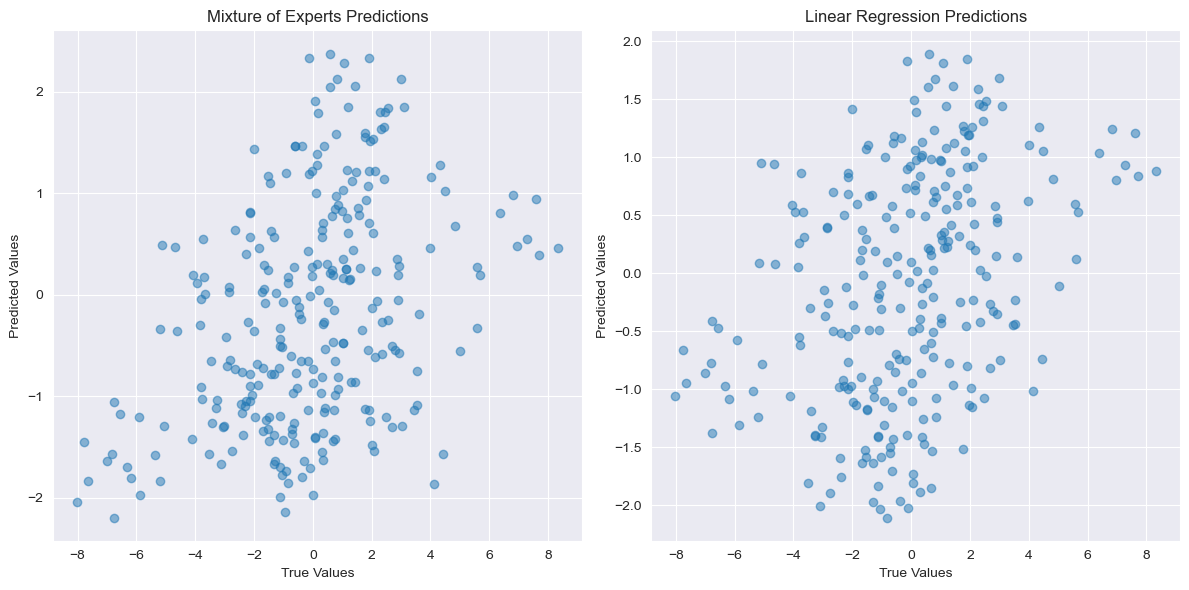

In [32]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_moe, alpha=0.5, label="Mixture of Experts")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Mixture of Experts Predictions")


plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_baseline, alpha=0.5, label="Linear Regression")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Linear Regression Predictions")

plt.tight_layout()
plt.show()

Дополнительно: постепенно делайте датасеты все более и более похожими и смотрите, как это влияет на bias, variance и разницу с обычной линейной регрессией (разница должна становиться меньше).

In [33]:
results_list = []

# Выберем разные значения похожести для датасетов
for similarity in [0.0, 0.25, 0.5, 0.75, 1.0]:
    np.random.seed(42)
    n_samples = 300

    # Постепенно делаем их более похожими
    X1 = np.random.uniform(-1, 1, size=(n_samples, 2))
    y1 = 3 * X1[:, 0] - 2 * X1[:, 1] + np.random.normal(0, 0.3, size=n_samples)

    X2 = np.random.uniform(-1, 1, size=(n_samples, 2))
    y2 = (1 - similarity) * (-4 * X2[:, 0] + 5 * X2[:, 1]) + similarity * (
        3 * X2[:, 0] - 2 * X2[:, 1]
    ) + np.random.normal(0, 0.3, size=n_samples)

    X3 = np.random.uniform(-1, 1, size=(n_samples, 2))
    y3 = (1 - similarity) * (2 * X3[:, 0] + 2 * X3[:, 1]) + similarity * (
        3 * X3[:, 0] - 2 * X3[:, 1]
    ) + np.random.normal(0, 0.3, size=n_samples)

    X = np.vstack([X1, X2, X3])
    y = np.hstack([y1, y2, y3])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    n_components = 3
    _, _, _, train_probabilities = em(X_train, n_components)
    _, _, _, test_probabilities = em(X_test, n_components)

    experts = []
    for component in range(3):
        weights = train_probabilities[:, component]
        weighted_X_train = X_train * weights[:, None]
        weighted_y_train = y_train * weights
        expert = LinearRegression()
        expert.fit(weighted_X_train, weighted_y_train)
        experts.append(expert)

    y_pred_moe = predict_moe(X_test, test_probabilities, experts)
    mse_moe = mean_squared_error(y_test, y_pred_moe)

    baseline_model = LinearRegression()
    baseline_model.fit(X_train, y_train)
    y_pred_baseline = baseline_model.predict(X_test)
    mse_baseline = mean_squared_error(y_test, y_pred_baseline)

    results_list.append({"Similarity": similarity, "MSE_MOE": mse_moe, "MSE_Baseline": mse_baseline})

results_df = pd.DataFrame(results_list)
print(results_df)


   Similarity   MSE_MOE  MSE_Baseline
0        0.00  6.728348      6.910577
1        0.25  3.824410      3.928112
2        0.50  1.749179      1.796369
3        0.75  0.502654      0.515350
4        1.00  0.084838      0.085054
